In [1]:
library(sm)
library(sandwich)
library(lmtest)
library(car)
library(AER)
library(zoo)
library(forecast)
data = read.csv("C:/Users/Sahab/Downloads/wk11_series.csv")
summary(data)


Package 'sm', version 2.2-5.4: type help(sm) for summary information
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: survival
Loading required package: timeDate


ERROR: Error: package or namespace load failed for 'forecast'


       X                x         
 Min.   :  1.00   Min.   : 36.00  
 1st Qu.: 93.75   1st Qu.: 57.38  
 Median :186.50   Median : 76.45  
 Mean   :186.50   Mean   : 84.83  
 3rd Qu.:279.25   3rd Qu.:111.53  
 Max.   :372.00   Max.   :152.60  

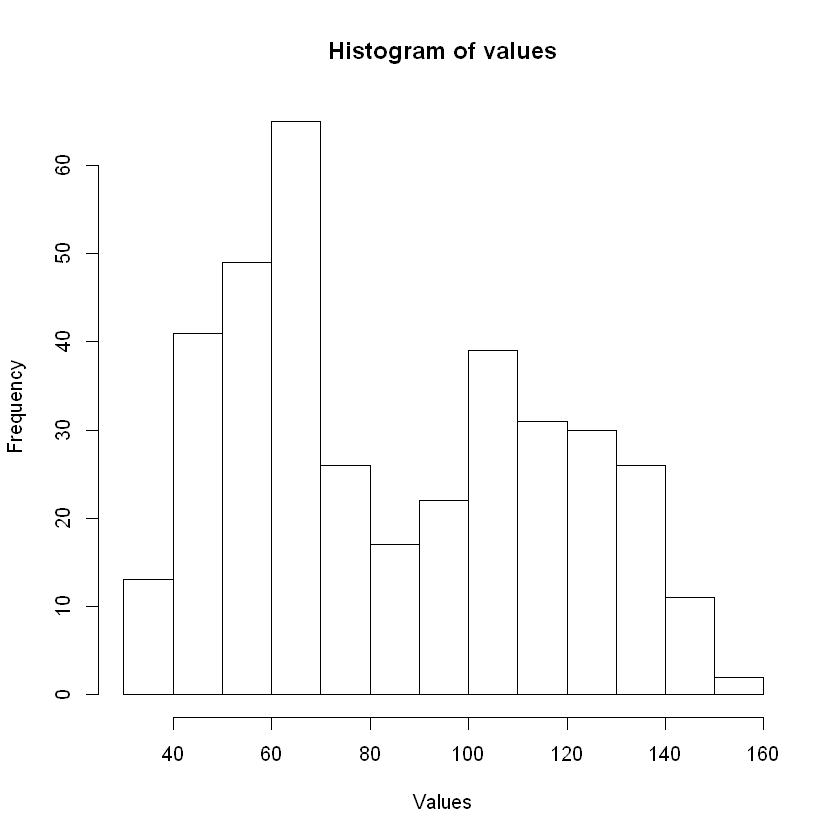

In [4]:
hist(data$x, main="Histogram of values", xlab="Values")

Histogram of the values looks a bit bimodal, and slightly skewed to the right


In [ ]:
par(mfrow=c(2,2))
plot.ts(data$x); title("Fig 1:  Series")
acf(data$x, main="Fig 2: ACF of the Series")
pacf(data$x, main="Fig 3: PACF of the Series")

The series look very persistent (ACF) and looks like a random walk with a drift. We will have to difference to see if we can have a stationary series.

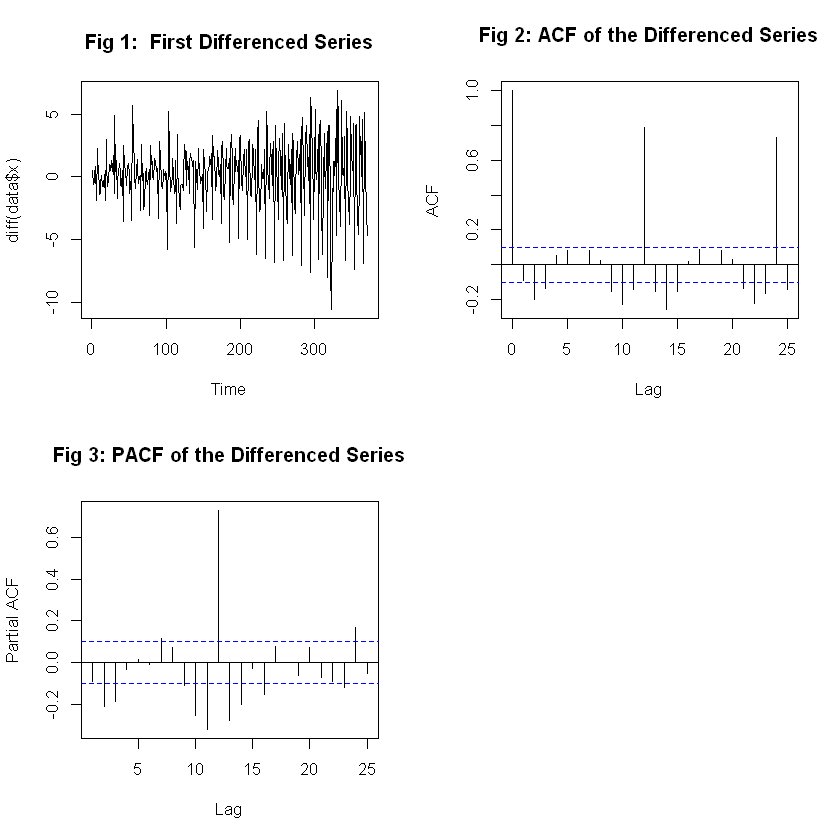

In [15]:
par(mfrow=c(2,2))
plot.ts(diff(data$x)); title("Fig 1:  First Differenced Series")
acf(diff(data$x), main="Fig 2: ACF of the Differenced Series") 
pacf(diff(data$x), main="Fig 3: PACF of the Differenced Series")

The series look stationary, but with non constant variance. But for this problem set, we will work with ARIMA.

From acf, it looks like monthly data because of huge lag at 12. The first lag is at 2, therefore we will pick AR(2), and try AR(12) as well. From PACF, we pick MA(2).

In [21]:
fitAR = arima(data$x, order=c(2,1,0))
#summary(fitAR) #aic = 1772.28
fitAR$aic

[1] 1772.284

In [22]:
fitRa12 = arima(data$x, order=c(12,1,0))
#summary(fitRa12) #aic = 1375.76
fitRa12$aic

[1] 1375.756

In [24]:
fitMA = arima(data$x, order=c(0,1,2))
fitMA$aic #aic = 1564.29

[1] 1769.746

Let's see what auto arima picks

fit = auto.arima(data$x)

summary(fit)

Warning message:
In auto.arima(data$x) :
  Unable to fit final model using maximum likelihood. AIC value approximated
> summary(fit) #AIC = 1696
Series: data$x 
ARIMA(2,1,2) with drift         

Coefficients:
         ar1      ar2      ma1     ma2   drift
      0.9895  -0.9739  -1.1057  0.9764  0.2599
s.e.  0.0133   0.0134   0.0112  0.0154  0.1045

sigma^2 estimated as 5.501:  log likelihood=-840.42
AIC=1695.43   AICc=1695.66   BIC=1718.93



So let's try these params, and tweak them a little

In [28]:
fit2 = arima(data$x, order=c(2,1,2), seasonal = list(order=c(2,1,2), period = 12))
#summary(fit2) #AIC = 1146
fit2$aic
fit3 = arima(data$x, order=c(12,1,2), seasonal = list(order=c(2,1,2), period = 12))
#summary(fit3) #AIC = 1152.98
fit3$aic

[1] 1146.891

[1] 1149.219

I will pick the parameter that auto arima function picked, but with the one that considers seasonality. 

summary(fit2)

Call:
arima(x = data$x, order = c(2, 1, 2), seasonal = list(order = c(2, 1, 2), period = 12))

Coefficients:
          ar1     ar2     ma1      ma2    sar1     sar2     sma1    sma2
      -0.2786  0.3396  0.5851  -0.0522  0.3822  -0.2970  -1.1301  0.4891
s.e.   0.2202  0.1644  0.2331   0.1752  0.1604   0.0748   0.1631  0.1146

sigma^2 estimated as 1.317:  log likelihood = -564.45,  aic = 1146.89

Training set error measures:
                     ME     RMSE       MAE        MPE     MAPE      MASE       ACF1
Training set 0.03216471 1.127363 0.8194894 0.03694486 1.046362 0.4165944 0.00151637

I will also evaluate this model , fit2, with auto arima.

Box.test(fit$residuals, type="Ljung-Box")

	Box-Ljung test

data:  fit$residuals
X-squared = 8.1018, df = 1, p-value = 0.004422


The values are not independently distributed for the model picked by auto arima

In [34]:
Box.test(fit2$residuals, type="Ljung-Box")


	Box-Ljung test

data:  fit2$residuals
X-squared = 9e-04, df = 1, p-value = 0.9766


Values seem to be independently distributed for our fit2 model.

Let's plot some residual

In [39]:
fit = arima(data$x, order=c(2,1,2))

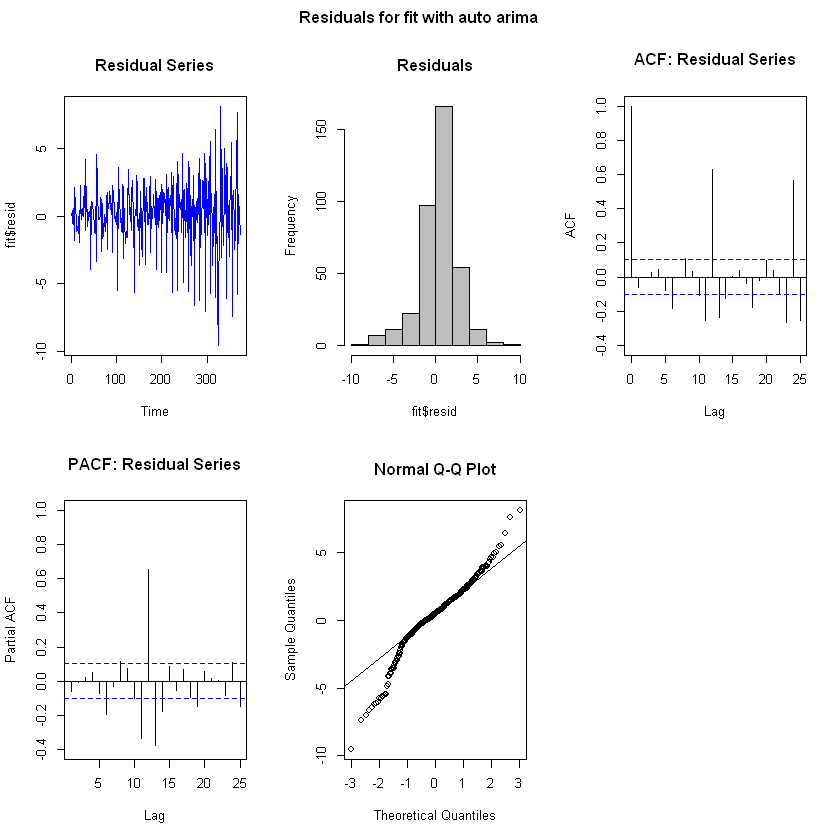

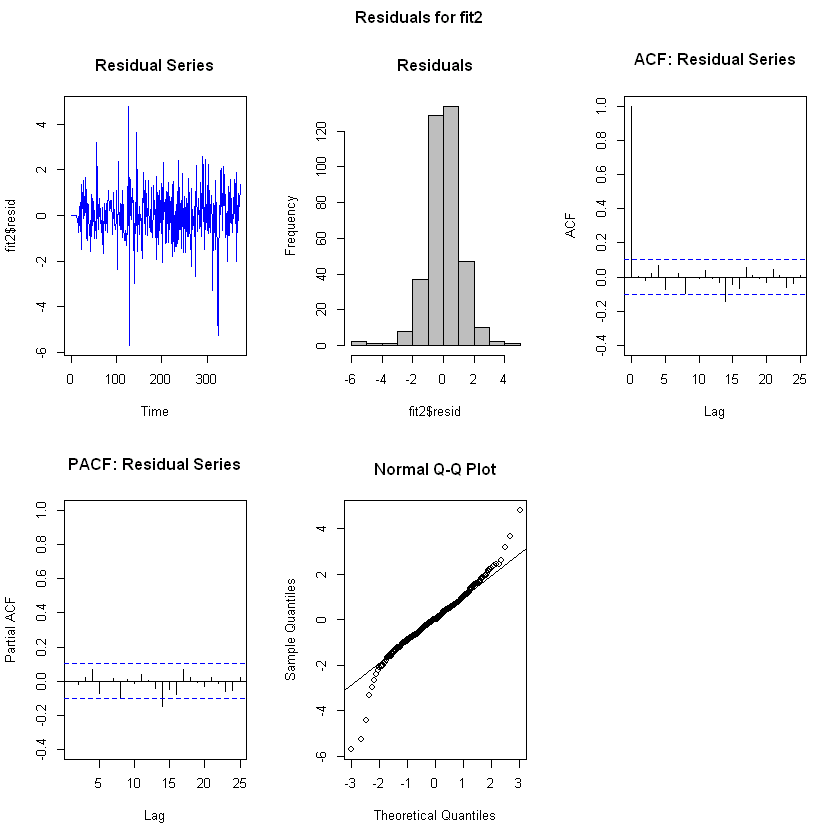

In [41]:
par(mfrow=c(2,3),  oma = c( 0, 0, 2, 0 ))
plot(fit$resid, col="blue", main="Residual Series")
hist(fit$resid, col="gray", main="Residuals")
acf(fit$resid , ylim=c(-0.4,1), main="ACF: Residual Series")
pacf(fit$resid, ylim=c(-0.4,1), main="PACF: Residual Series")
qqnorm(fit$residuals)
qqline(fit$residuals)
title( "Residuals for fit with auto arima", outer = TRUE )

par(mfrow=c(2,3),  oma = c( 0, 0, 2, 0 ))
plot(fit2$resid, col="blue", main="Residual Series")
hist(fit2$resid, col="gray", main="Residuals")
acf(fit2$resid , ylim=c(-0.4,1), main="ACF: Residual Series")
pacf(fit2$resid, ylim=c(-0.4,1), main="PACF: Residual Series")
qqnorm(fit2$residuals)
qqline(fit2$residuals)
title( "Residuals for fit2", outer = TRUE )


Our model fit2 plots for the acf and pacf of residuals look like noise, while auto arima's do not. The residual plot for auto arima looks like it has nonconstant variance.

In [ ]:
plot.ts(data$x, col="navy", 
        main="Original vs Estimated Series ",
        ylab="Simulated and Estimated Values", lty=2)
lines(fitted(fit2),col="green")
leg.txt <- c("Original Series", "Estimated Series")
legend("topright", legend=leg.txt, lty=c(2,1), 
       col=c("navy","green"), bty='n', cex=1)

In [ ]:
plot(forecast(fit2, 12), main= "predicted values")

These last functions were not working in jupyter, but the estimated series look very close to the original. 